# Ookla Broadband Performance Data

This notebook downloads and explores Ookla open data for fixed and mobile broadband performance.

**Important**: Run the cells in order, starting with the configuration cell below.

In [1]:
# Enable IPython autoreload for modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
# Load configuration
data_dir = None # TO silence Pylance, data_dir is defined by the cofig.py file. 
%run ../../config.py

from lib import download_ookla_files, get_ookla_data, list_ookla_objects, build_files_df

Project root: /Users/eric/proj/scratch/WirelessIncome
Data directory: /Users/eric/proj/scratch/WirelessIncome/data


In [2]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import os
from urllib.parse import urlparse

# Create S3 client with no signing (for public buckets)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# List parquet URIs from Ookla bucket
parquet_files = list_ookla_objects(s3)

# Build dataset of file paths with metadata
files_df = build_files_df(parquet_files)

files_df.head(20)

,path,service_type,year,quarter
0,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,1
1,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,2
2,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,3
3,s3://ookla-open-data/parquet/performance/type=...,fixed,2019,4
4,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,1
5,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,2
6,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,3
7,s3://ookla-open-data/parquet/performance/type=...,fixed,2020,4
8,s3://ookla-open-data/parquet/performance/type=...,fixed,2021,1
9,s3://ookla-open-data/parquet/performance/type=...,fixed,2021,2


In [3]:
files_df.iloc[0]


path            s3://ookla-open-data/parquet/performance/type=...
service_type                                                fixed
year                                                         2019
quarter                                                         1
Name: 0, dtype: object

In [4]:
files_df.year.value_counts()

year
2019    8
2020    8
2021    8
2022    8
2023    8
2024    8
2025    6
Name: count, dtype: int64

In [5]:
# Download mobile parquet files for all 2022 quarters
mobile_2022 = download_ookla_files(
    files_df,
    years=2022,
    quarters=[1,2,3,4],
    service_type='mobile',
    data_dir=data_dir,
    s3=s3
)

print(f"Returned rows: {len(mobile_2022)}")
mobile_2022.head()

Found 4 mobile files for years=[2022], quarters=[1, 2, 3, 4]
2022-01-01_performance_mobile_tiles.parquet already exists, skipping
2022-04-01_performance_mobile_tiles.parquet already exists, skipping
2022-07-01_performance_mobile_tiles.parquet already exists, skipping
2022-10-01_performance_mobile_tiles.parquet already exists, skipping

Downloaded 4 files
Returned rows: 4


,path,service_type,year,quarter,local_path
39,s3://ookla-open-data/parquet/performance/type=...,mobile,2022,1,/Users/eric/proj/scratch/WirelessIncome/data/2...
40,s3://ookla-open-data/parquet/performance/type=...,mobile,2022,2,/Users/eric/proj/scratch/WirelessIncome/data/2...
41,s3://ookla-open-data/parquet/performance/type=...,mobile,2022,3,/Users/eric/proj/scratch/WirelessIncome/data/2...
42,s3://ookla-open-data/parquet/performance/type=...,mobile,2022,4,/Users/eric/proj/scratch/WirelessIncome/data/2...


In [6]:
# Load multiple quarters/service types at once
# (ensure the files have been downloaded first)
df = get_ookla_data(
    files_df=files_df,
    year=[2022],
    quarter=[1, 2, 3, 4],
    service_type=["mobile"],
    data_dir=data_dir,
)

Loading 2022-01-01_performance_mobile_tiles.parquet...
  Loaded 3820724 rows
Loading 2022-04-01_performance_mobile_tiles.parquet...
  Loaded 4027744 rows
Loading 2022-07-01_performance_mobile_tiles.parquet...
  Loaded 4046154 rows
Loading 2022-10-01_performance_mobile_tiles.parquet...
  Loaded 3838065 rows
Concatenated 4 files -> 15732687 total rows


In [7]:
df.shape

(15732687, 14)

In [8]:
# Inspect which metadata combinations are present after concatenation
t = (
    df[["ookla_year", "ookla_quarter", "ookla_service_type"]]
    .drop_duplicates()
    .sort_values(["ookla_service_type", "ookla_year", "ookla_quarter"])
)
t

,ookla_year,ookla_quarter,ookla_service_type
0,2022,1,mobile
3820724,2022,2,mobile
7848468,2022,3,mobile
11894622,2022,4,mobile


In [9]:
import geopandas as gpd
from shapely.geometry import Point

# Convert DataFrame to GeoDataFrame using tile_x and tile_y as Point geometry
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(x, y) for x, y in zip(df['tile_x'], df['tile_y'])],
    crs='EPSG:4326'  # WGS84 lat/lon
)

print(f"Created GeoDataFrame with {len(gdf)} points")
gdf.head()

Created GeoDataFrame with 15732687 points


,quadkey,tile,tile_x,tile_y,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry
0,0022133222312322,"POLYGON((-160.02685546875 70.6435894914449, -1...",-160.0241,70.6427,19110,7891,77,NaN,NaN,3,2,2022,1,mobile,POINT (-160.0241 70.6427)
1,0022133222330023,"POLYGON((-160.043334960938 70.6363054807905, -...",-160.0406,70.6354,21870,11875,83,NaN,NaN,2,1,2022,1,mobile,POINT (-160.0406 70.6354)
2,0022133222330032,"POLYGON((-160.037841796875 70.6363054807905, -...",-160.0351,70.6354,14567,14691,75,NaN,NaN,9,2,2022,1,mobile,POINT (-160.0351 70.6354)
3,0022133222330100,"POLYGON((-160.02685546875 70.6417687358462, -1...",-160.0241,70.6409,5468,9886,83,NaN,NaN,1,1,2022,1,mobile,POINT (-160.0241 70.6409)
4,0022133222330102,"POLYGON((-160.02685546875 70.6399478155463, -1...",-160.0241,70.6390,24311,16243,72,NaN,NaN,1,1,2022,1,mobile,POINT (-160.0241 70.639)


In [10]:
# Sample and filter the data
t = gdf

t = t[t['quadkey'].str.startswith('0')]

# Drop coordinate and quadkey columns
uss_gdf = t.drop(columns=['quadkey', 'tile_x', 'tile_y', 'tile'])
uss_gdf.head()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,ookla_year,ookla_quarter,ookla_service_type,geometry
0,19110,7891,77,NaN,NaN,3,2,2022,1,mobile,POINT (-160.0241 70.6427)
1,21870,11875,83,NaN,NaN,2,1,2022,1,mobile,POINT (-160.0406 70.6354)
2,14567,14691,75,NaN,NaN,9,2,2022,1,mobile,POINT (-160.0351 70.6354)
3,5468,9886,83,NaN,NaN,1,1,2022,1,mobile,POINT (-160.0241 70.6409)
4,24311,16243,72,NaN,NaN,1,1,2022,1,mobile,POINT (-160.0241 70.639)


In [11]:
uss_gdf.shape

(4066168, 11)

<Axes: >

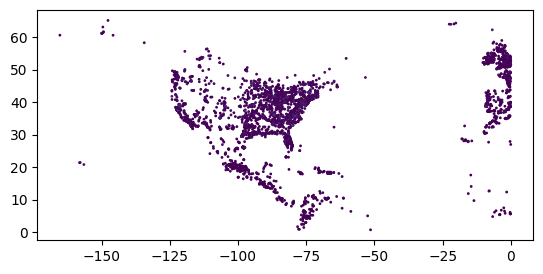

In [12]:
uss_gdf.sample(4000).plot(markersize=1, column="avg_d_kbps")


In [13]:
uss_gdf[uss_gdf.avg_d_kbps > 10000].sample(4000).avg_d_kbps.describe()

count    4.000000e+03
mean     1.183933e+05
std      1.719656e+05
min      1.000100e+04
25%      2.770350e+04
50%      6.174500e+04
75%      1.431528e+05
max      3.683527e+06
Name: avg_d_kbps, dtype: float64

In [14]:
# Save to parquet file
import os
output_path = data_dir / 'uss_mobile_2022.parquet'
print(type(uss_gdf))
uss_gdf.to_parquet(output_path)
print(f"Saved {len(uss_gdf)} rows to {output_path}")

<class 'geopandas.geodataframe.GeoDataFrame'>
Saved 4066168 rows to /Users/eric/proj/scratch/WirelessIncome/data/uss_mobile_2022.parquet


<Axes: >

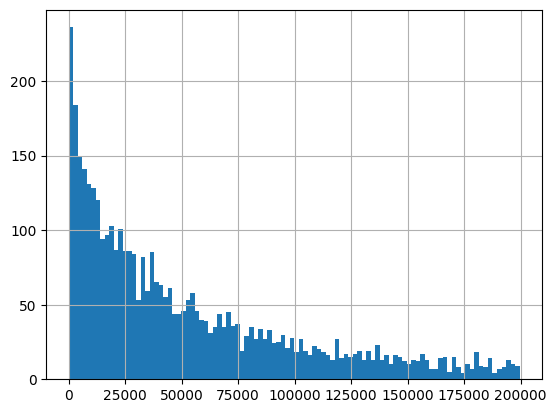

In [15]:
uss_gdf.avg_d_kbps[uss_gdf.avg_d_kbps < .2e6].sample(4000).hist(bins=100)